In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import joblib
import os

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/BTECH/2nd Year/4th Sem/Projects/GEN AI/DATASET/personal_loan_dataset_updated.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df.columns)

Index(['Annual Income', 'Credit Score', 'Loan Amount', 'Loan Tenure',
       'Monthly Expenses', 'Age', 'Existing Loans', 'Loan Approved',
       'Employment_Employed', 'Employment_Self-Employed', 'Residence_Owned',
       'Residence_Rented', 'LoanPurpose_Education',
       'LoanPurpose_Home Renovation', 'LoanPurpose_Medical',
       'LoanPurpose_Wedding', 'Marital_Married', 'Marital_Single'],
      dtype='object')


In [ ]:
# Smart feature: ApprovalBoost (just as feature, not label editor)
def apply_custom_weights(row):
    score = 0
    if 25 <= row['Age'] <= 60:
        score += 1
    if row['Credit Score'] > 700:
        score += 1
    if row['Employment_Employed'] == 1:
        score += 1
    if row['Residence_Owned'] == 1:
        score += 1
    if row['Existing Loans'] <= row['Annual Income'] * 0.4:
        score += 1
    if row['Existing Loans'] <= row['Monthly Expenses'] * 12:
        score += 1
    return score

df['ApprovalBoost'] = df.apply(apply_custom_weights, axis=1)

# Separate features and target
X = df.drop('Loan Approved', axis=1)
y = df['Loan Approved']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

# Build ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    class_weight=class_weights)

# Save model and scaler
model.save('loan_app/ml_model/loan_ann_model.h5')
joblib.dump(scaler, 'loan_app/ml_model/scaler.pkl')

# Create plot dir
plot_dir = 'loan_app/static/loan_app/plots'
os.makedirs(plot_dir, exist_ok=True)

# Accuracy and Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/ann_loss_accuracy.png')
plt.close()

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.savefig(f'{plot_dir}/confusion_matrix.png')
plt.close()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6755 - loss: 0.7304 - val_accuracy: 0.7400 - val_loss: 0.5832
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7370 - loss: 0.5325 - val_accuracy: 0.8000 - val_loss: 0.4733
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8343 - loss: 0.3900 - val_accuracy: 0.8400 - val_loss: 0.3486
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8603 - loss: 0.3003 - val_accuracy: 0.8150 - val_loss: 0.3769
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8778 - loss: 0.2242 - val_accuracy: 0.8750 - val_loss: 0.2467
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9196 - loss: 0.2140 - val_accuracy: 0.8700 - val_loss: 0.2693
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9209 - loss: 0.1778 - val_accuracy: 0.8800 - val_loss: 0.2632
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.1704 - val_accuracy: 0.8700 - val_loss: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred, zero_division=0)*100
recall = recall_score(y_test, y_pred, zero_division=0)*100
f1 = f1_score(y_test, y_pred, zero_division=0)*100
ann_acc = history.history['val_accuracy'][-1]*100

# Print Evaluation
print("\nModel Evaluation Metrics:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1-Score     : {f1:.4f}")
print(f"ANN Accuracy : {ann_acc:.4f}")


Model Evaluation Metrics:
Accuracy     : 95.5000
Precision    : 63.6364
Recall       : 93.3333
F1-Score     : 75.6757
ANN Accuracy : 95.0000


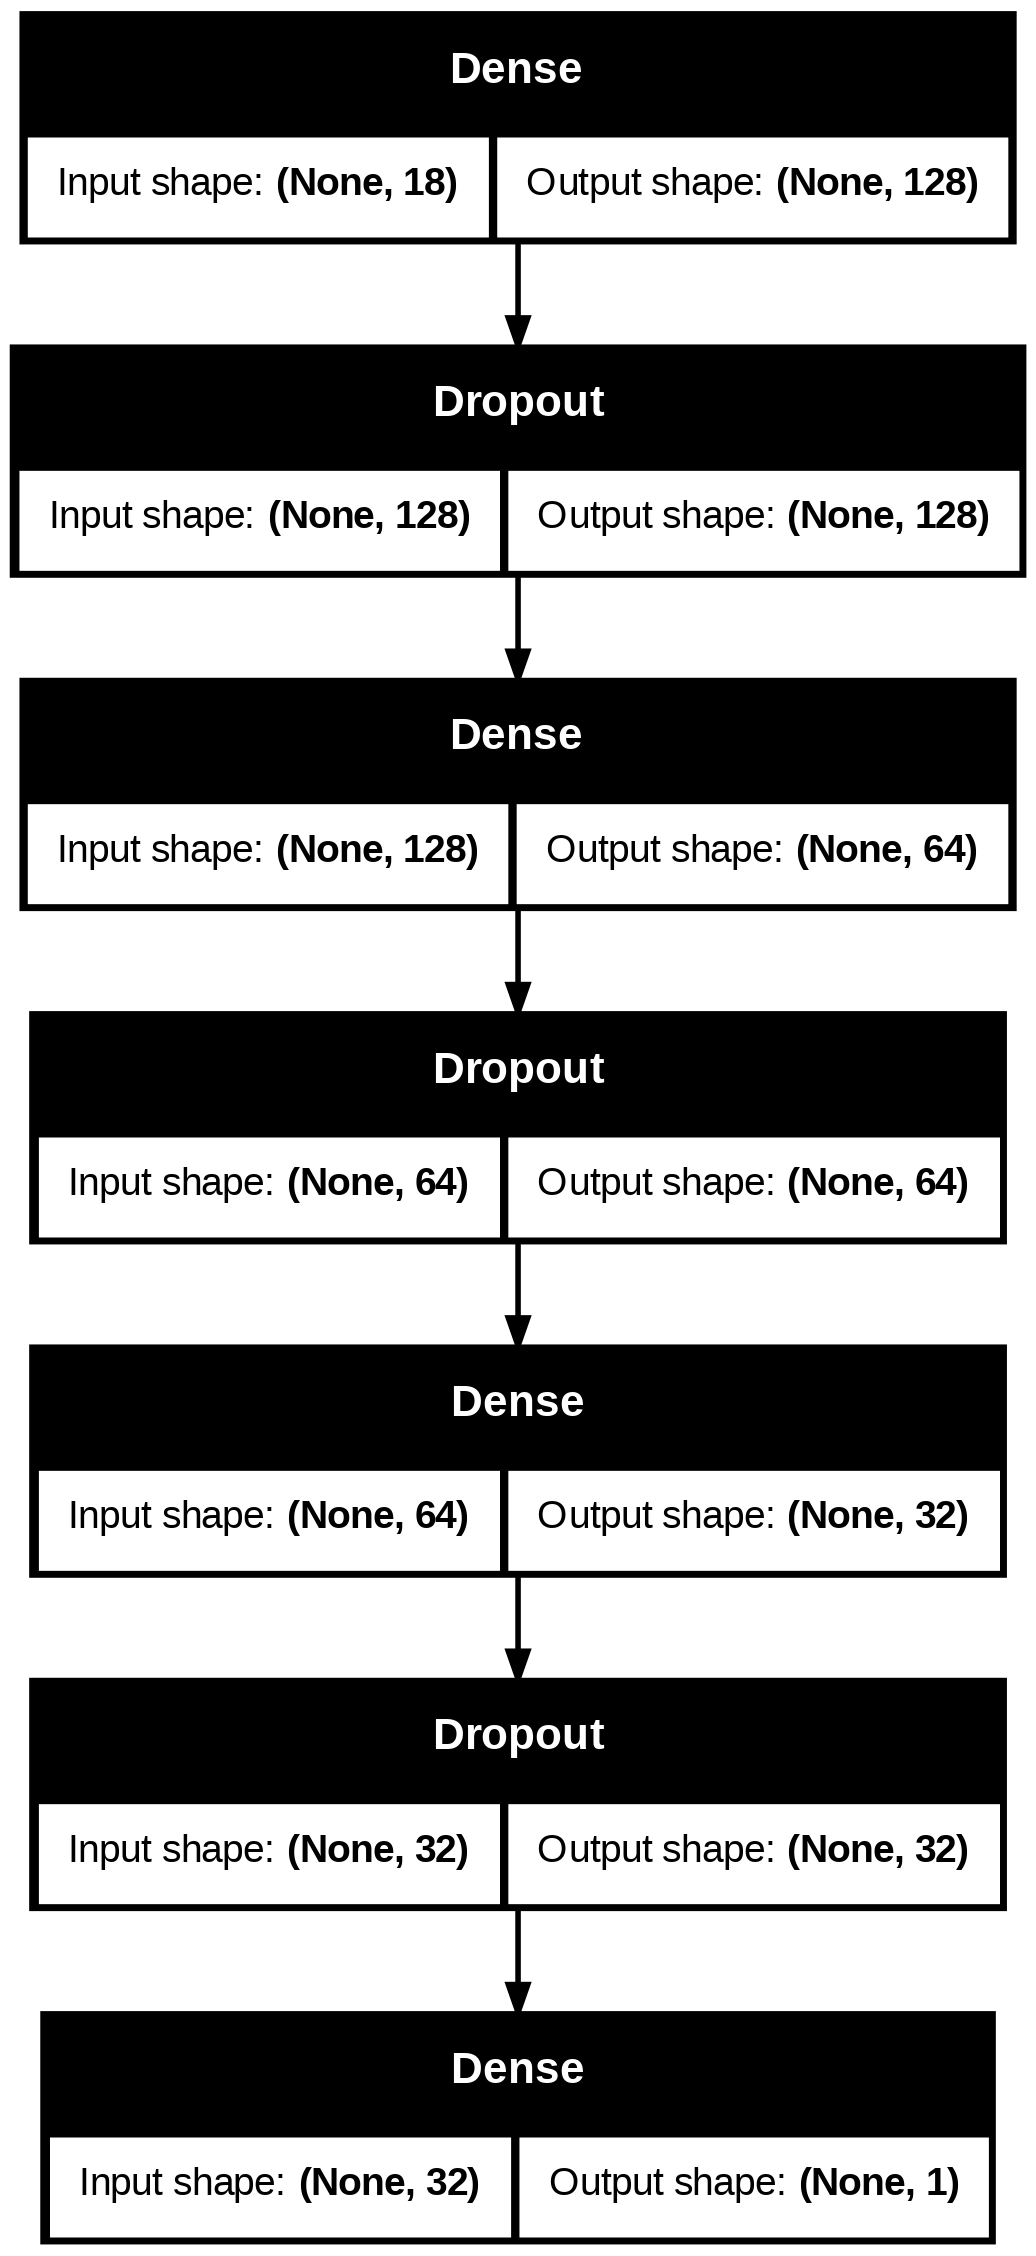

In [ ]:
plot_model(model, to_file=f'{plot_dir}/ann_architecture.png', show_shapes=True)